**In this notebook, we prepare the dataset to be used as input for the regression analysis:** 
    
    - I load raw COMIX data on the participants (+ matched SEP index)
    - I load raw COMIX data on the contacts 
    - I select surveys A1, B1, F1
    - I compute the number of contacts per participant
    - I save the dataset to be used in the regression analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import cm
import geopandas as gp 
from shapely.geometry import Point, LineString

import datetime as dt

import time

# choose overall/outside household, unweighted/weighted

In [2]:
sep_type, cont_type = ("weightedSEP", "cont_overall")

#sep_type, cont_type = ("unweightedSEP", "cont_overall")
#sep_type, cont_type = ("weightedSEP", "cont_outside_home_inclnan")
#sep_type, cont_type = ("weightedSEP", "cont_outside_home_exclnan")

#sep_type, cont_type = ("weightedSEP", "cont_work")


sep_type, cont_type

('weightedSEP', 'cont_overall')

# load COMIX data on participants (with SEP)

In [3]:
#comix_part = pd.read_csv("./../../../1_SEP_analysis/data_processed/comixdata_part_cleaned+sep_munic.csv", 
#                        low_memory=False)
comix_part = pd.read_csv("./../data/comixdata_part_cleaned+sep_munic.csv", low_memory=False)

In [4]:
comix_part.head()

,part_id,panel_wave_id,date,panel_wave,age_part,part_age_est_min,part_age_est_max,lower.age.limit,gender,gender_responder,...,drops,missing,name_munic_strip,name_munic_transl,name,sep3-w-avg,sep3-u-avg,pop_densit,COUNTOFPER,geometry
0,101560,A1_101560,2021-01-23,A1,24,24,24,18,Male,Male,...,Drop out,1,Basel,Basel,Basel,64.970380,69.242426,80.328851,170669,"POLYGON ((2611151 1270169, 2611325 1271036, 26..."
1,101560,A6_101560,2021-05-02,A6,24,25,25,18,Male,Male,...,Drop out,1,Basel,Basel,Basel,64.970380,69.242426,80.328851,170669,"POLYGON ((2611151 1270169, 2611325 1271036, 26..."
2,101560,A3_101560,2021-03-09,A3,24,24,24,18,Male,Male,...,Drop out,1,Basel,Basel,Basel,64.970380,69.242426,80.328851,170669,"POLYGON ((2611151 1270169, 2611325 1271036, 26..."
3,101561,A1_101561,2021-01-22,A1,55,55,55,50,Male,Male,...,Drop out,1,Erlinsbach,Erlinsbach (AG),Erlinsbach (AG),65.669473,68.161558,79.987729,3788,"POLYGON ((2641397 1253237, 2643507 1253510, 26..."
4,101561,A6_101561,2021-05-01,A6,55,55,55,50,Male,Male,...,Drop out,1,Erlinsbach,Erlinsbach (AG),Erlinsbach (AG),65.669473,68.161558,79.987729,3788,"POLYGON ((2641397 1253237, 2643507 1253510, 26..."


In [5]:
## participants with info on municipalities 
ll = comix_part.iloc[comix_part['name_munic_transl'].dropna().index]['panel_wave'].unique()
ll.sort()
ll

array(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'B1', 'B2', 'B3', 'B4',
       'B5', 'B6', 'C1', 'C2', 'D1', 'E1', 'E2', 'F1', 'F2', 'F3', 'F4',
       'F5', 'F6'], dtype=object)

In [6]:
comix_part = comix_part[comix_part['panel_wave'].isin(['A1', 'B1', 'F1', 
                                                       'C1', 'D1', 'E1'])].copy()

In [7]:
comix_part['age_part'].unique()

array(['24', '55', '67', '72', '60', '23', '35', '19', '64', '33', '61',
       '74', '48', '57', '25', '56', '54', '70', '36', '59', '30', '58',
       '47', '45', '22', '50', '69', '68', '52', '65', '44', '32', '34',
       '21', '66', '63', '53', '27', '46', '37', '20', '41', '38', '71',
       '83', '62', '29', '39', '31', '43', '28', '18', '75', '49', '73',
       '77', '76', '78', '40', '26', '79', '51', '42', '84', '80', '85',
       '81', '82', '86', '1-4', '16-17', '5-11', '12-15', '0-1'],
      dtype=object)

In [8]:
len(comix_part)

4462

In [9]:
len(comix_part[comix_part['panel_wave'].isin(['A1', 'B1', 'F1'])])

3552

In [10]:
len(comix_part[comix_part['panel_wave'].isin(['C1', 'D1', 'E1'])])

910

In [11]:
comix_part[comix_part['panel_wave'].isin(['C1', 'D1', 'E1'])]['age_part'].unique()

array(['1-4', '16-17', '5-11', '12-15', '0-1'], dtype=object)

In [12]:
comix_part[comix_part['panel_wave'].isin(['C1', 'D1', 'E1'])]['education_level'].value_counts()

education_level
Vocational education                                331
Higher education (e.g., Bachelor, Master or PhD)    244
Advanced vocational education                       177
Gymnasium                                           120
Obligatory school                                    38
Name: count, dtype: int64

In [13]:
comix_part[comix_part['panel_wave'].isin(['C1', 'D1', 'E1'])]['education_level3'].value_counts()

education_level3
Obligatory school and vocational education          369
Gymnasium and advanced vocational education         297
Higher education (e.g., Bachelor, Master or PhD)    244
Name: count, dtype: int64

In [14]:
comix_part[comix_part['panel_wave'].isin(['C1', 'D1', 'E1'])]['education_level3_v2'].value_counts()

education_level3_v2
Upper-secondary level                451
Tertiary level                       421
Without post-compulsory education     38
Name: count, dtype: int64

In [15]:
comix_part.columns

Index(['part_id', 'panel_wave_id', 'date', 'panel_wave', 'age_part',
       'part_age_est_min', 'part_age_est_max', 'lower.age.limit', 'gender',
       'gender_responder', 'zip_code', 'name_munic', 'id_distr', 'name_distr',
       'region', 'canton', 'region_ch', 'grossregion', 'region_urban_rural',
       'occupation', 'employment', 'household_income', 'education_level',
       'language_ch', 'country_birth', 'country_mother', 'country_father',
       'years_ch', 'vaccinated', 'vaccine_doses', 'vaccine_dose1_date',
       'vaccine_dose2_date', 'vaccine_dose3_date',
       'change_behavior_after_vaccine', 'change_behavior', 'vaccine_want',
       'motivation_vaccinated', 'why_notvaccinated', 'got_booster',
       'encourage_vaccination', 'agreement_measures', 'no_contacts',
       'covid_serious_forme', 'covid_likelytochatch',
       'covid_worried_spreading', 'pos_last2w', 'pos', 'pregnant', 'riskgroup',
       'household_size', 'household_riskgroup', 'survey_group', 'sex',
       'se

# load COMIX data on contacts for survey A1, B1, F1, 'C1', 'D1', 'E1'

In [16]:
#comix_cont = pd.read_csv("./../../0_github_ISPMBern_comix_new/output/comixdata_cont_cleaned.csv")
comix_cont = pd.read_csv("./../data/comixdata_cont_cleaned.csv")

comix_cont = comix_cont[comix_cont['panel_wave'].isin(['A1', 'B1', 'F1',
                                                       'C1', 'D1', 'E1'])].copy()

In [17]:
comix_cont.head()

,panel_wave_id,panel_wave,cnt_gender,cnt_age,cnt_age_est_min,cnt_age_est_max,num_cnt_beforeCOVID19,cnt_relationship,hh_riskgroup,hh_education,...,cnt_duration,cnt_dis_meters,cnt_dis_hands,cnt_dis_mask,cnt_dis_measures,cnt_place_main,cnt_place,cnt_freq,cnt_dis_physical,contact
0,F1_114551,F1,NaN,0-18,0,18,NaN,NaN,NaN,NaN,...,"15 minutes or more, but less than 1 hour",NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,mass
1,F1_114551,F1,NaN,0-18,0,18,NaN,NaN,NaN,NaN,...,"15 minutes or more, but less than 1 hour",NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,mass
2,F1_114551,F1,NaN,0-18,0,18,NaN,NaN,NaN,NaN,...,"15 minutes or more, but less than 1 hour",NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,mass
3,F1_114551,F1,NaN,0-18,0,18,NaN,NaN,NaN,NaN,...,"15 minutes or more, but less than 1 hour",NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,mass
4,F1_114551,F1,NaN,0-18,0,18,NaN,NaN,NaN,NaN,...,"15 minutes or more, but less than 1 hour",NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,mass


In [18]:
comix_part['employment_cat'].unique()

array(['Employed', 'Retired', 'Student', 'Homemaker', 'Unemployed',
       'Other unemployed situation'], dtype=object)

In [19]:
comix_cont.groupby('cnt_age').size()

cnt_age
0-1                      185
0-18                    3922
1-4                      859
10-14                    371
12-15                    570
15-19                    258
16-17                    239
18-19                    203
18-65                   7019
20-24                    861
25-34                   2013
35-44                   2170
45-54                   1997
5-11                    1144
5-9                      517
55-64                   1477
65+                     3186
65-69                    550
70-74                    421
75-79                    260
80-84                    119
85+                       95
Don’t know               282
Prefer not to answer     100
dtype: int64

In [20]:
len(comix_cont[comix_cont['cnt_age'].isna()])

6254

In [21]:
comix_cont.groupby('cnt_age').size().sum()

28818

In [22]:
comix_cont.columns

Index(['panel_wave_id', 'panel_wave', 'cnt_gender', 'cnt_age',
       'cnt_age_est_min', 'cnt_age_est_max', 'num_cnt_beforeCOVID19',
       'cnt_relationship', 'hh_riskgroup', 'hh_education', 'hh_occupation',
       'cnt_duration', 'cnt_dis_meters', 'cnt_dis_hands', 'cnt_dis_mask',
       'cnt_dis_measures', 'cnt_place_main', 'cnt_place', 'cnt_freq',
       'cnt_dis_physical', 'contact'],
      dtype='object')

In [23]:
len(comix_cont)

35072

In [24]:
comix_cont.groupby('cnt_age').size().sum()+len(comix_cont[comix_cont['cnt_age'].isna()])

35072

In [25]:
1-len(comix_cont[((comix_cont['cnt_age'].isna()) |
                (comix_cont['cnt_age'].isin(['Don’t know', 
                                            'Prefer not to answer'])))])/len(comix_cont)

0.8107892335766423

In [26]:
len(comix_cont) - len(comix_cont[((comix_cont['cnt_age'].isna()) |
                (comix_cont['cnt_age'].isin(['Don’t know', 
                                            'Prefer not to answer'])))]), len(comix_cont)

(28436, 35072)

# compute number of contacts per participant

In [27]:
comix_cont['cnt_place'].unique()

array([nan, 'not specified', 'home', 'outdoors', 'house', 'work',
       'shop but not essential', 'shop', 'entertainment place',
       'health care', 'public tansport', 'sport', 'school',
       'aesthetic care', 'worship', 'other'], dtype=object)

In [28]:
len(comix_cont['cnt_place'].unique())

16

In [29]:
len(['outdoors', 'worship',  'shop', 'health care', 'work', 'aesthetic care', 
     'public tansport', 'entertainment place', 
     'school', 'shop but not essential', 'sport'])

11

In [30]:
if cont_type == "cont_overall":
    print("keep all contacts")
    
elif cont_type == "cont_outside_home_inclnan":
    # filter on locations outside the household
    comix_cont = comix_cont[comix_cont['cnt_place'].isin(['home', 'house'])==False]
    
elif cont_type == "cont_outside_home_exclnan":
    # filter on explicit locations outside the household (excluding nans and unspecified)
    comix_cont = comix_cont[comix_cont['cnt_place'].isin(['home', 'house', 'not specified'])==False]
    comix_cont = comix_cont[comix_cont['cnt_place'].isna() == False]
    
elif cont_type == "cont_work":
    comix_cont = comix_cont[comix_cont['cnt_place'].isin(['work'])==True]
    
else:
    print("define filter for contacts")
    sys.exit()

keep all contacts


In [31]:
comix_cont_per_part = comix_cont.groupby('panel_wave_id').size().reset_index()
comix_cont_per_part.columns = ['panel_wave_id', 'contacts']

In [32]:
comix_cont_per_part

,panel_wave_id,contacts
0,A1_101561,7
1,A1_101562,2
2,A1_101563,3
3,A1_101564,2
4,A1_101565,8
...,...,...
3972,F1_115485,2
3973,F1_115486,8
3974,F1_115487,9
3975,F1_115488,3


In [33]:
comix_part_merged = pd.merge(comix_part, comix_cont_per_part, how='left')

comix_part_merged['contacts_fill0'] = comix_part_merged['contacts'].fillna(0)

In [34]:
comix_part_merged.head()

,part_id,panel_wave_id,date,panel_wave,age_part,part_age_est_min,part_age_est_max,lower.age.limit,gender,gender_responder,...,name_munic_strip,name_munic_transl,name,sep3-w-avg,sep3-u-avg,pop_densit,COUNTOFPER,geometry,contacts,contacts_fill0
0,101560,A1_101560,2021-01-23,A1,24,24,24,18,Male,Male,...,Basel,Basel,Basel,64.970380,69.242426,80.328851,170669,"POLYGON ((2611151 1270169, 2611325 1271036, 26...",NaN,0.0
1,101561,A1_101561,2021-01-22,A1,55,55,55,50,Male,Male,...,Erlinsbach,Erlinsbach (AG),Erlinsbach (AG),65.669473,68.161558,79.987729,3788,"POLYGON ((2641397 1253237, 2643507 1253510, 26...",7.0,7.0
2,101562,A1_101562,2021-01-22,A1,67,67,67,60,Male,Male,...,Renens (VD),Renens (VD),Renens (VD),53.089003,60.254796,58.087553,15506,"POLYGON ((2534830 1155260, 2535410 1154958, 25...",2.0,2.0
3,101563,A1_101563,2021-01-22,A1,72,72,72,70,Female,Female,...,Landquart,Landquart,Landquart,56.741330,60.158006,27.706804,9046,"MULTIPOLYGON (((2761595 1204182, 2763038 12043...",3.0,3.0
4,101564,A1_101564,2021-01-22,A1,60,60,60,60,Male,Male,...,Emmen,Emmen,Emmen,56.595116,60.420055,47.660013,30281,"POLYGON ((2666225 1217653, 2668162 1218138, 26...",2.0,2.0


In [35]:
comix_part_merged['contacts_fill0'].max()

2356.0

# add truncation at 50 contacts

In [36]:
comix_part_merged['contacts_trunc50'] = comix_part_merged['contacts'].apply(lambda x: 50 if x>50 else x)
comix_part_merged['contacts_fill0_trunc50'] = comix_part_merged['contacts_fill0'].apply(lambda x: 50 if x>50 else x)

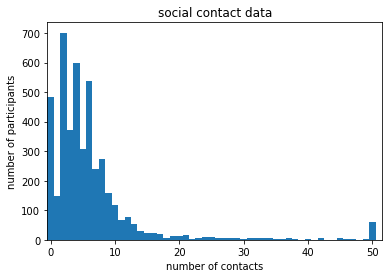

In [37]:
plt.hist(comix_part_merged['contacts_fill0_trunc50'], bins = np.arange(-0.5, 51.5, 1))
plt.xlim([-0.5, 51.5])
plt.title("social contact data")
plt.ylabel("number of participants")
plt.xlabel("number of contacts")
#plt.yscale('log')
plt.show()

In [38]:
comix_part_merged[comix_part_merged['contacts_fill0_trunc50']==50]

,part_id,panel_wave_id,date,panel_wave,age_part,part_age_est_min,part_age_est_max,lower.age.limit,gender,gender_responder,...,name,sep3-w-avg,sep3-u-avg,pop_densit,COUNTOFPER,geometry,contacts,contacts_fill0,contacts_trunc50,contacts_fill0_trunc50
28,101588,A1_101588,2021-01-22,A1,47,47,47,40,Male,Male,...,La Chaux-de-Fonds,53.958931,57.293900,19.333333,35087,"POLYGON ((2556134 1215632, 2556579 1215050, 25...",118.0,118.0,50.0,50.0
73,101634,A1_101634,2021-01-23,A1,22,22,22,18,Male,Male,...,Saanen,57.564050,57.947720,16.667007,7340,"POLYGON ((2586374 1156762, 2587945 1159220, 25...",151.0,151.0,50.0,50.0
82,101643,A1_101643,2021-01-24,A1,24,24,24,18,Male,Male,...,Reichenburg,57.066040,56.966390,22.712209,3622,"POLYGON ((2716100 1226465, 2716895 1226973, 27...",59.0,59.0,50.0,50.0
89,101650,A1_101650,2021-01-25,A1,25,25,25,18,Female,Female,...,Zollikon,81.700708,82.824444,114.593824,12936,"POLYGON ((2689615 1245507, 2689737 1245010, 26...",112.0,112.0,50.0,50.0
253,101814,A1_101814,2021-01-25,A1,52,52,52,50,Female,Female,...,Basel,64.970380,69.242426,80.328851,170669,"POLYGON ((2611151 1270169, 2611325 1271036, 26...",135.0,135.0,50.0,50.0
290,101851,A1_101851,2021-01-25,A1,34,34,34,30,Male,Male,...,Schaffhausen,62.135743,65.323069,44.573674,35123,"POLYGON ((2683250 1289145, 2684760 1289778, 26...",53.0,53.0,50.0,50.0
293,101854,A1_101854,2021-01-25,A1,53,53,53,50,Male,Male,...,Opfikon,65.384485,68.122240,84.327207,17994,"POLYGON ((2684190 1255012, 2687045 1254565, 26...",68.0,68.0,50.0,50.0
779,102341,A1_102341,2021-01-26,A1,25,25,25,18,Male,Male,...,Therwil,74.423928,76.478305,59.474798,11731,"POLYGON ((2607375 1261587, 2610875 1261911, 26...",84.0,84.0,50.0,50.0
781,102343,A1_102343,2021-01-26,A1,45,45,45,40,Male,Male,...,Bern,68.090075,70.886968,38.441400,132730,"POLYGON ((2598864 1198220, 2598213 1198413, 25...",227.0,227.0,50.0,50.0
797,102359,A1_102359,2021-01-26,A1,54,54,54,50,Male,Male,...,Langenthal,61.663402,64.260427,7.388128,15451,"POLYGON ((2630223 1227278, 2628905 1226495, 26...",113.0,113.0,50.0,50.0


# prepare additional columns as variables for the regression analysis

## age

In [39]:
comix_part_merged['age_part'].unique()

array(['24', '55', '67', '72', '60', '23', '35', '19', '64', '33', '61',
       '74', '48', '57', '25', '56', '54', '70', '36', '59', '30', '58',
       '47', '45', '22', '50', '69', '68', '52', '65', '44', '32', '34',
       '21', '66', '63', '53', '27', '46', '37', '20', '41', '38', '71',
       '83', '62', '29', '39', '31', '43', '28', '18', '75', '49', '73',
       '77', '76', '78', '40', '26', '79', '51', '42', '84', '80', '85',
       '81', '82', '86', '1-4', '16-17', '5-11', '12-15', '0-1'],
      dtype=object)

In [40]:
'16-17' < '25'

True

In [41]:
comix_part_merged['age_group_part'] = comix_part_merged['age_part'].apply(lambda x:
                                            '0-14' if x in ['0-1', '1-4', '5-11', '12-15'] else                           
                                            ('15-24' if str(x)<'25' else
                                            ('25-64' if str(x)<'65' else 
                                            ('65+'))))  

In [42]:
for group in comix_part_merged['age_group_part'].unique():
    dd = comix_part_merged[comix_part_merged['age_group_part']==group].copy()
    print(group)
    print(dd['age_part'].unique())

15-24
['24' '23' '19' '22' '21' '20' '18' '16-17']
25-64
['55' '60' '35' '64' '33' '61' '48' '57' '25' '56' '54' '36' '59' '30'
 '58' '47' '45' '50' '52' '44' '32' '34' '63' '53' '27' '46' '37' '41'
 '38' '62' '29' '39' '31' '43' '28' '49' '40' '26' '51' '42']
65+
['67' '72' '74' '70' '69' '68' '65' '66' '71' '83' '75' '73' '77' '76'
 '78' '79' '84' '80' '85' '81' '82' '86']
0-14
['1-4' '5-11' '12-15' '0-1']


## gender

In [43]:
comix_part_merged['gender'].unique()

array(['Male', 'Female', 'In another way', 'Prefer not to answer'],
      dtype=object)

In [44]:
comix_part_merged['gender_responder'].unique()

array(['Male', 'Female', nan], dtype=object)

In [45]:
comix_part_merged[comix_part_merged['gender_responder'].isna()]

,part_id,panel_wave_id,date,panel_wave,age_part,part_age_est_min,part_age_est_max,lower.age.limit,gender,gender_responder,...,sep3-w-avg,sep3-u-avg,pop_densit,COUNTOFPER,geometry,contacts,contacts_fill0,contacts_trunc50,contacts_fill0_trunc50,age_group_part
606,102167,A1_102167,2021-01-26,A1,21,21,21,18,In another way,NaN,...,59.015061,60.643035,29.619965,1827,"POLYGON ((2717130 1093015, 2717666 1092672, 27...",6.0,6.0,6.0,6.0,15-24
1446,103013,A1_103013,2021-02-01,A1,28,28,28,18,Prefer not to answer,NaN,...,68.647740,70.911421,51.548470,427912,"POLYGON ((2688122 1247659, 2689015 1246832, 26...",2.0,2.0,2.0,2.0,25-64
1810,110784,B1_110784,2021-06-07,B1,27,27,27,18,In another way,NaN,...,65.801353,65.751785,12.910112,4976,"POLYGON ((2603845 1214195, 2602355 1213765, 26...",8.0,8.0,8.0,8.0,25-64
2490,111468,B1_111468,2021-06-14,B1,34,34,34,30,In another way,NaN,...,63.633956,66.884029,20.098493,21806,"POLYGON ((2718590 1261037, 2720820 1261798, 27...",4.0,4.0,4.0,4.0,25-64
3092,114999,F1_114999,2021-12-10,F1,50,50,50,50,In another way,NaN,...,66.306596,66.798243,23.108407,1981,"POLYGON ((2634557 1270467, 2635542 1268945, 26...",NaN,0.0,NaN,0.0,25-64


In [46]:
comix_part_merged['gender_responder'] = comix_part_merged['gender'].apply(lambda x: 
                                                           'Male' if x=='Male' else 
                                                          ("Female" if x == "Female" else "Other"))

In [47]:
comix_part_merged['gender_responder'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

## other variables

In [48]:
comix_part_merged['region'].unique()

array(['Urban', 'Rural'], dtype=object)

In [49]:
comix_part_merged['country_cat_birth'].unique()

array(['Switzerland', 'EU', 'Unknown', 'Non-EU'], dtype=object)

In [50]:
comix_part_merged['household_income_3cat'].unique()               

array(['0-5,000', '10,000+', 'Preferred not to answer', '5,001-10,000'],
      dtype=object)

In [51]:
comix_part_merged['vaccinated'].unique()               

array([ 0.,  1., nan])

In [52]:
comix_part_merged[comix_part_merged['vaccinated'].isna()]

,part_id,panel_wave_id,date,panel_wave,age_part,part_age_est_min,part_age_est_max,lower.age.limit,gender,gender_responder,...,sep3-w-avg,sep3-u-avg,pop_densit,COUNTOFPER,geometry,contacts,contacts_fill0,contacts_trunc50,contacts_fill0_trunc50,age_group_part
4017,906536,D1_906536,2021-07-14,D1,5-11,5,11,5,Female,Female,...,57.829629,63.940062,46.791195,18924,"POLYGON ((2553678 1146523, 2554128 1146455, 25...",4.0,4.0,4.0,4.0,0-14
4279,907514,E1_907514,2022-01-15,E1,1-4,1,4,0,Female,Female,...,54.201054,56.036697,61.814168,6758,"POLYGON ((2558250 1156522, 2558878 1156818, 25...",6.0,6.0,6.0,6.0,0-14
4390,907625,E1_907625,2022-01-17,E1,5-11,5,11,5,Male,Male,...,66.936335,70.870562,32.210323,14831,"POLYGON ((2621375 1260977, 2623047 1260812, 26...",3.0,3.0,3.0,3.0,0-14


In [53]:
comix_part_merged['vaccinated'] = comix_part_merged['vaccinated'].fillna(0.)

In [54]:
comix_part_merged['vaccinated'].unique()               

array([0., 1.])

## education level

In [55]:
comix_part_merged['education_level3'].unique()

array(['Obligatory school and vocational education',
       'Higher education (e.g., Bachelor, Master or PhD)',
       'Gymnasium and advanced vocational education'], dtype=object)

In [56]:
comix_part_merged['education_level'].unique()

array(['Vocational education',
       'Higher education (e.g., Bachelor, Master or PhD)', 'Gymnasium',
       'Advanced vocational education', 'Obligatory school'], dtype=object)

In [57]:
comix_part_merged[comix_part_merged['age_group_part']=='0-14']['education_level'].value_counts()

education_level
Vocational education                                306
Higher education (e.g., Bachelor, Master or PhD)    230
Advanced vocational education                       165
Gymnasium                                           113
Obligatory school                                    37
Name: count, dtype: int64

In [58]:
comix_part_merged[comix_part_merged['panel_wave']=='C1'][['age_part','education_level']]

,age_part,education_level
3552,1-4,Gymnasium
3553,16-17,Vocational education
3554,1-4,Advanced vocational education
3555,5-11,Vocational education
3556,1-4,"Higher education (e.g., Bachelor, Master or PhD)"
...,...,...
4009,16-17,Vocational education
4011,1-4,Advanced vocational education
4013,12-15,Gymnasium
4014,1-4,Advanced vocational education


In [59]:
comix_part_merged['education_level3_v3'] = comix_part_merged['education_level'].apply(lambda x: 
                                                            'Without tertiary education' 
                                            if x in ['Obligatory school', 'Gymnasium', 'Vocational education']
                                                    else 'Tertiary level')

In [60]:
comix_part_merged['age_part'].unique()

array(['24', '55', '67', '72', '60', '23', '35', '19', '64', '33', '61',
       '74', '48', '57', '25', '56', '54', '70', '36', '59', '30', '58',
       '47', '45', '22', '50', '69', '68', '52', '65', '44', '32', '34',
       '21', '66', '63', '53', '27', '46', '37', '20', '41', '38', '71',
       '83', '62', '29', '39', '31', '43', '28', '18', '75', '49', '73',
       '77', '76', '78', '40', '26', '79', '51', '42', '84', '80', '85',
       '81', '82', '86', '1-4', '16-17', '5-11', '12-15', '0-1'],
      dtype=object)

In [61]:
### force education level for children <18 y.o. to be "without tertiary education"
### the participant information on education level refers to the parents, not the children 

for edu in ['education_level3', 'education_level3_v2', 'education_level3_v3', 'education_level']:
    comix_part_merged[edu] = comix_part_merged[[edu, 'age_part']].apply(lambda x: 'Without tertiary education' 
                                                                        if x[1] in ['0-1', '1-4', '5-11', '12-15', '16-17']
                                                                        else x[0], axis=1)

## employment status and household size

In [62]:
comix_part_merged['employment_cat'].unique()

array(['Employed', 'Retired', 'Student', 'Homemaker', 'Unemployed',
       'Other unemployed situation'], dtype=object)

In [63]:
comix_part_merged['employment_cat'] = comix_part_merged[['employment_cat', 'age_part']].apply(lambda x: 'Student' 
                                                                    if x[1] in ['0-1', '1-4', '5-11', '12-15', '16-17']
                                                                    else x[0], axis=1)

In [64]:
comix_part_merged['employment_cat_v2'] = comix_part_merged['employment_cat'].apply(lambda x: 
                                                           'employed' if x=='Employed' else 'not employed')

In [65]:
comix_part_merged[comix_part_merged['age_part'].isin(['0-1', '1-4', '5-11', '12-15', '16-17'])]['employment_cat_v2'].value_counts()

employment_cat_v2
not employed    910
Name: count, dtype: int64

In [66]:
comix_part_merged['household_size_cat'].unique()

array(['5+', '4', '2', '3', '1'], dtype=object)

In [67]:
comix_part_merged['household_size_cat_v2'] = comix_part_merged['household_size_cat'].apply(lambda x: 
                                                           '3+' if x in ['3', '4', '5+'] else x)

## weekday / weekend

In [68]:
comix_part_merged["date"].unique()

array(['2021-01-23', '2021-01-22', '2021-01-26', '2021-01-27',
       '2021-01-24', '2021-01-25', '2021-01-28', '2021-02-01',
       '2021-01-29', '2021-06-03', '2021-06-14', '2021-06-07',
       '2021-06-04', '2021-06-05', '2021-06-06', '2021-06-09',
       '2021-06-08', '2021-06-10', '2021-06-11', '2021-06-12',
       '2021-06-13', '2021-12-09', '2021-12-13', '2021-12-16',
       '2021-12-10', '2021-12-14', '2021-12-11', '2021-12-12',
       '2021-12-15', '2021-12-18', '2021-12-17', '2021-12-19',
       '2021-02-05', '2021-07-08', '2021-07-12', '2021-07-09',
       '2021-07-13', '2021-07-10', '2021-07-14', '2021-02-06',
       '2021-02-07', '2021-02-08', '2021-07-11', '2021-02-09',
       '2021-07-15', '2022-01-12', '2022-01-14', '2022-01-13',
       '2022-01-15', '2022-01-16', '2022-01-17'], dtype=object)

In [69]:
from datetime import timedelta

# participants are asked on day d to report contacts on the previous day (d-1)
comix_part_merged["date_contact"] = pd.to_datetime(comix_part_merged["date"]) - timedelta(days=1)

# index for day of week (from 0 to 6, with 5 and 6 being saturday and sunday)
comix_part_merged['type_of_day'] = comix_part_merged["date_contact"].apply(lambda x: x.weekday())

comix_part_merged['weekend'] = comix_part_merged['type_of_day'].apply(lambda x: 0 if x<5 else 1)

In [70]:
comix_part_merged['type_of_day'].unique()

array([4, 3, 0, 1, 5, 6, 2])

In [71]:
comix_part_merged.groupby("weekend").size()/len(comix_part_merged)

weekend
0    0.72277
1    0.27723
dtype: float64

In [72]:
5/7, 2/7

(0.7142857142857143, 0.2857142857142857)

## population density

In [73]:
d_low = comix_part_merged['pop_densit'].quantile(0.25)
d_high = comix_part_merged['pop_densit'].quantile(0.75)
comix_part_merged['pop_densit_cat3'] = comix_part_merged['pop_densit'].apply(lambda x: 'low' if x < d_low
                                                                            else ('high' if x > d_high else
                                                                            'baseline'))

## SEP

In [83]:
#sep_by_munic = gp.read_file("./../../../1_SEP_analysis/data_processed/weighted_mean_sep/municipality_mean_sep.shp")
sep_by_munic = pd.read_csv("./../data/municipality_mean_sep.csv")
    
if sep_type == "weightedSEP":
    #q_lo = sep_by_munic['sep3-w-avg'].quantile(0.33)
    q_me = sep_by_munic['sep3-w-avg'].quantile(0.50)
    #q_up = sep_by_munic['sep3-w-avg'].quantile(0.67)
    
    comix_part_merged['sep3_quartile'] = comix_part_merged['sep3-w-avg'].apply(lambda x: 
                                        'lowest' if x<q_me else ('highest'))
        
elif sep_type == "unweightedSEP":
    #q_lo = sep_by_munic['sep3-u-avg'].quantile(0.33)
    q_me = sep_by_munic['sep3-u-avg'].quantile(0.50)
    #q_up = sep_by_munic['sep3-u-avg'].quantile(0.67)
    
    comix_part_merged['sep3_quartile'] = comix_part_merged['sep3-u-avg'].apply(lambda x: 
                                        'lowest' if x<q_me else ('highest'))
else:
    sys.exit()

In [84]:
comix_part_merged.head()

,part_id,panel_wave_id,date,panel_wave,age_part,part_age_est_min,part_age_est_max,lower.age.limit,gender,gender_responder,...,contacts_fill0_trunc50,age_group_part,education_level3_v3,employment_cat_v2,household_size_cat_v2,date_contact,type_of_day,weekend,pop_densit_cat3,sep3_quartile
0,101560,A1_101560,2021-01-23,A1,24,24,24,18,Male,Male,...,0.0,15-24,Without tertiary education,employed,3+,2021-01-22,4,0,high,highest
1,101561,A1_101561,2021-01-22,A1,55,55,55,50,Male,Male,...,7.0,25-64,Tertiary level,employed,3+,2021-01-21,3,0,high,highest
2,101562,A1_101562,2021-01-22,A1,67,67,67,60,Male,Male,...,2.0,65+,Without tertiary education,not employed,2,2021-01-21,3,0,baseline,lowest
3,101563,A1_101563,2021-01-22,A1,72,72,72,70,Female,Female,...,3.0,65+,Without tertiary education,not employed,2,2021-01-21,3,0,baseline,lowest
4,101564,A1_101564,2021-01-22,A1,60,60,60,60,Male,Male,...,2.0,25-64,Without tertiary education,employed,2,2021-01-21,3,0,baseline,lowest


# save dataframe for statistical analysis 

In [85]:
file_name = "./../data/processed/comixdata_part_cleaned+sep_munic+{}.csv".format(sep_type, cont_type)

comix_part_merged.to_csv(file_name, index=False)

In [86]:
comix_part_merged.columns

Index(['part_id', 'panel_wave_id', 'date', 'panel_wave', 'age_part',
       'part_age_est_min', 'part_age_est_max', 'lower.age.limit', 'gender',
       'gender_responder', 'zip_code', 'name_munic', 'id_distr', 'name_distr',
       'region', 'canton', 'region_ch', 'grossregion', 'region_urban_rural',
       'occupation', 'employment', 'household_income', 'education_level',
       'language_ch', 'country_birth', 'country_mother', 'country_father',
       'years_ch', 'vaccinated', 'vaccine_doses', 'vaccine_dose1_date',
       'vaccine_dose2_date', 'vaccine_dose3_date',
       'change_behavior_after_vaccine', 'change_behavior', 'vaccine_want',
       'motivation_vaccinated', 'why_notvaccinated', 'got_booster',
       'encourage_vaccination', 'agreement_measures', 'no_contacts',
       'covid_serious_forme', 'covid_likelytochatch',
       'covid_worried_spreading', 'pos_last2w', 'pos', 'pregnant', 'riskgroup',
       'household_size', 'household_riskgroup', 'survey_group', 'sex',
       'se